In [2]:
import astropy
import astropy.units as u
import numpy as np
import specutils
import matplotlib.pyplot as plt
import pandas as pd
import inspect
import FunctionLib as FL

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning, append=True)

In [3]:
DJA_File_Path_str=os.path.expanduser('~/DJAData/')
DJA_Catalog_DataFrame=pd.read_csv('./DJACatalog.csv')

if os.path.exists(DJA_File_Path_str):
    DJA_File_list=np.array(os.listdir(DJA_File_Path_str))
print('Number of files in DJA directory:', len(DJA_File_list))

Number of files in DJA directory: 18507


In [4]:
DJA_File_List=[f for f in os.listdir('./') if f.startswith('goodsn')]
print('Number of files in current directory:', len(DJA_File_List))

Number of files in current directory: 3


In [5]:
redshift=FL.Load_Redshift(DJA_Catalog_DataFrame, DJA_File_List[1])
print('Redshift:', redshift)

Redshift: 4.7275


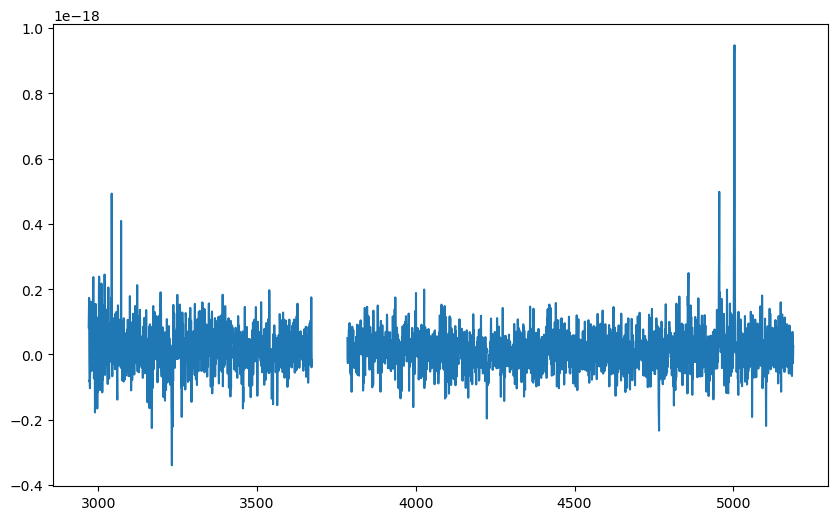

In [6]:
Spectrum=FL.Load_N_Rescale_Spectra(os.path.join(DJA_File_Path_str, DJA_File_List[2]))
Spectrum=FL.Calibrate_Spectra_To_RestFrame(Spectrum, redshift)
plt.figure(figsize=(10, 6))
plt.plot(Spectrum.wavelength, Spectrum.flux, label='Rest Frame Spectrum')

In [7]:
Spectrum.flux

<Quantity [nan, nan, nan, ..., nan, nan, nan] erg / (Angstrom s cm2)>

In [13]:
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.fitting import find_lines_threshold, find_lines_derivative
from astropy import units as u
from astropy.modeling import models
from scipy.optimize import curve_fit


In [106]:
Spectrum.wavelength

<SpectralAxis [2898.2977059 , 2898.95618318, 2899.61466045, ..., 5532.86528596,
   5533.52376324, 5534.18224051] Angstrom>

(4700.0, 5100.0)

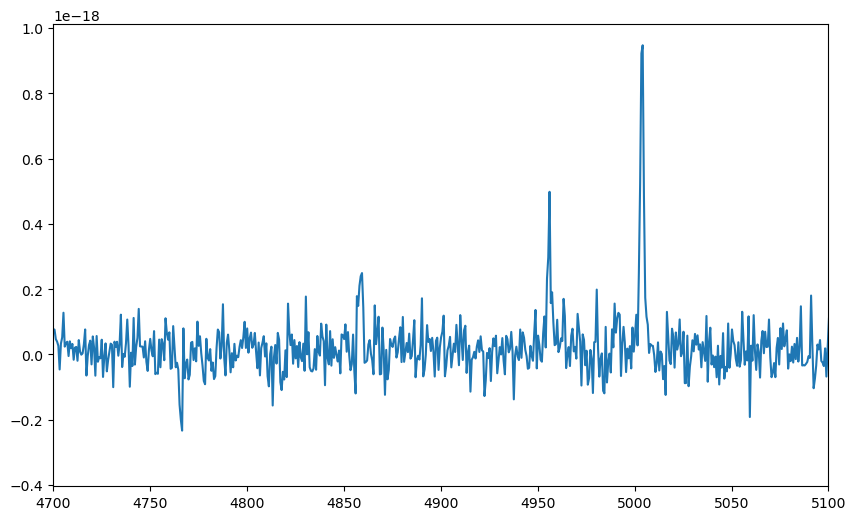

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(Spectrum.wavelength, Spectrum.flux, label='Rest Frame Spectrum')
plt.xlim(4700,5100)

In [11]:
def Gaussian(x, amplitude, mean, sigma, offset=0):
    return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2)) + offset

In [26]:
wavelength=Spectrum.spectral_axis.value
flux=Spectrum.flux.value
#if nan in flux:
flux=np.nan_to_num(flux, nan=0.0)

In [27]:
wavelength[np.argmax(flux)]  # Find the peak wavelength

np.float64(0.5004108033578356)

In [32]:
#select the wavelength range from 0.47 to 0.52
mask = (wavelength >= 0.4700) & (wavelength <= 0.5200)
wavelength_range = wavelength[mask]
flux_range = flux[mask]

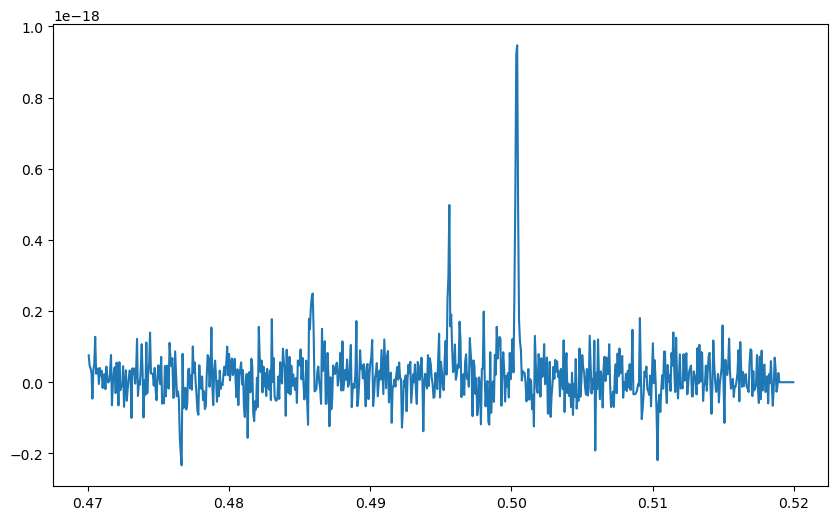

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(wavelength_range, flux_range, label='Selected Wavelength Range')

In [35]:
amplitude_guess=np.max(flux)-np.min(flux)
mean_guess=wavelength[np.argmax(flux)]
sigma_guess=(wavelength[-1]-wavelength[0])/10
offset_guess=np.min(flux)
initial_guess = [amplitude_guess, mean_guess, sigma_guess, offset_guess]

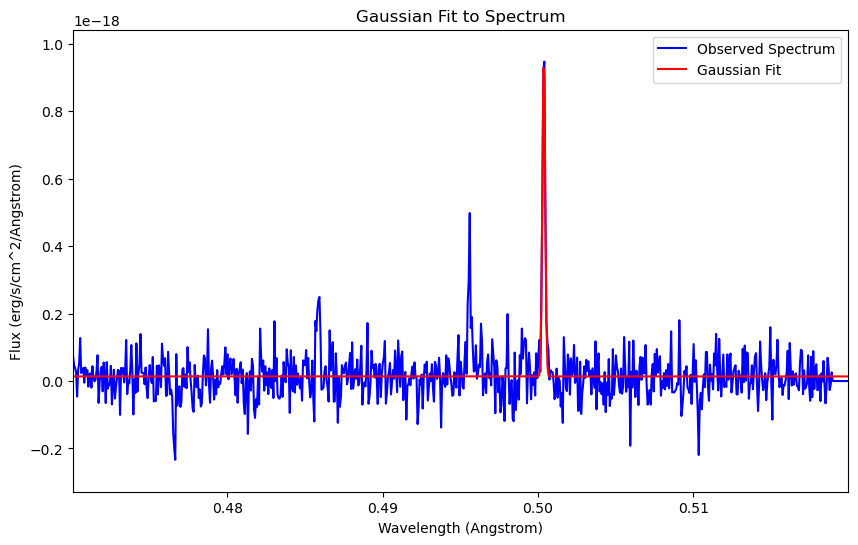

Fitted parameters:
Amplitude: 9.690135532364914e-19
Mean: 0.5003752876580011
Sigma: 8.929690635459552e-05
Offset: 1.3653676217511158e-20


In [38]:
popt, pcov = curve_fit(Gaussian, wavelength_range, flux_range, p0=initial_guess,maxfev=800000)
amp_fit, mean_fit, sigma_fit, offset_fit = popt

x_fit= wavelength_range
y_fit = Gaussian(x_fit, *popt)
plt.figure(figsize=(10, 6))
plt.plot(wavelength_range, flux_range, label='Observed Spectrum', color='blue')
plt.plot(x_fit, y_fit, label='Gaussian Fit', color='red')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Gaussian Fit to Spectrum')
plt.legend()
plt.xlim(wavelength_range[0], wavelength_range[-1])
plt.ylim(np.min(flux_range)-0.1*np.max(flux_range), np.max(flux_range)+0.1*np.max(flux_range))
plt.show()
print(f"Fitted parameters:\nAmplitude: {amp_fit}\nMean: {mean_fit}\nSigma: {sigma_fit}\nOffset: {offset_fit}")

In [39]:
flux_range= flux_range - y_fit

In [40]:
amplitude_guess=np.max(flux_range)-np.min(flux_range)
mean_guess=wavelength_range[np.argmax(flux_range)]
sigma_guess=(wavelength_range[-1]-wavelength_range[0])/10
offset_guess=np.min(flux_range)
initial_guess = [amplitude_guess, mean_guess, sigma_guess, offset_guess]

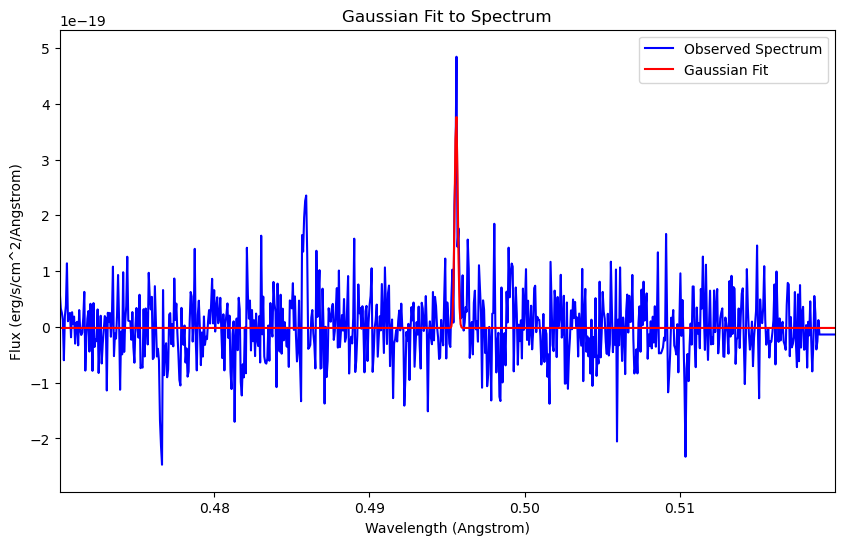

Fitted parameters:
Amplitude: 3.8364333576451985e-19
Mean: 0.49558730270313206
Sigma: -9.869011523583492e-05
Offset: -1.898928210739422e-21


In [41]:
popt, pcov = curve_fit(Gaussian, wavelength_range, flux_range, p0=initial_guess,maxfev=800000)
amp_fit, mean_fit, sigma_fit, offset_fit = popt

x_fit= wavelength_range
y_fit = Gaussian(x_fit, *popt)
plt.figure(figsize=(10, 6))
plt.plot(wavelength_range, flux_range, label='Observed Spectrum', color='blue')
plt.plot(x_fit, y_fit, label='Gaussian Fit', color='red')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Gaussian Fit to Spectrum')
plt.legend()
plt.xlim(wavelength_range[0], wavelength_range[-1])
plt.ylim(np.min(flux_range)-0.1*np.max(flux_range), np.max(flux_range)+0.1*np.max(flux_range))
plt.show()
print(f"Fitted parameters:\nAmplitude: {amp_fit}\nMean: {mean_fit}\nSigma: {sigma_fit}\nOffset: {offset_fit}")

(0.4700550009482611, 0.5199675784459995)

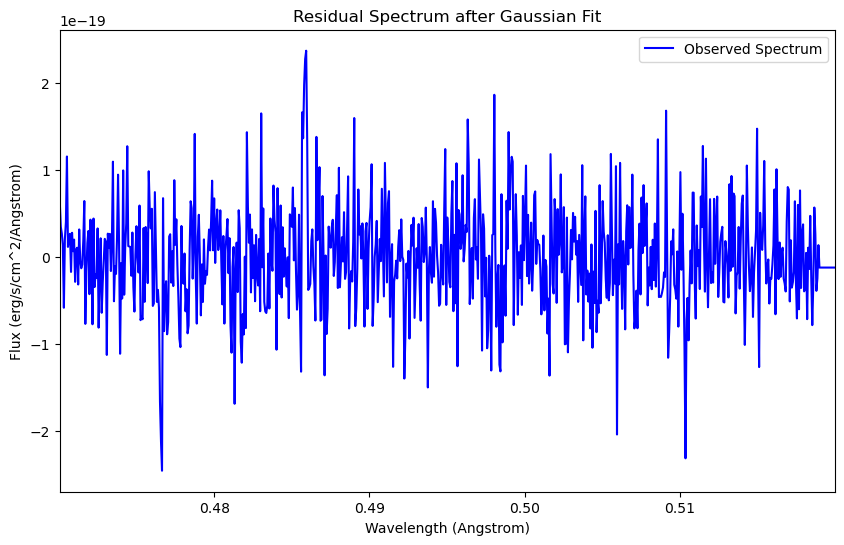

In [42]:
flux_range-= y_fit
plt.figure(figsize=(10, 6))
plt.plot(wavelength_range, flux_range, label='Observed Spectrum', color='blue')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Residual Spectrum after Gaussian Fit')
plt.legend()
plt.xlim(wavelength_range[0], wavelength_range[-1])

In [43]:
amplitude_guess=np.max(flux_range)-np.min(flux_range)
mean_guess=wavelength_range[np.argmax(flux_range)]
sigma_guess=(wavelength_range[-1]-wavelength_range[0])/10
offset_guess=np.min(flux_range)
initial_guess = [amplitude_guess, mean_guess, sigma_guess, offset_guess]

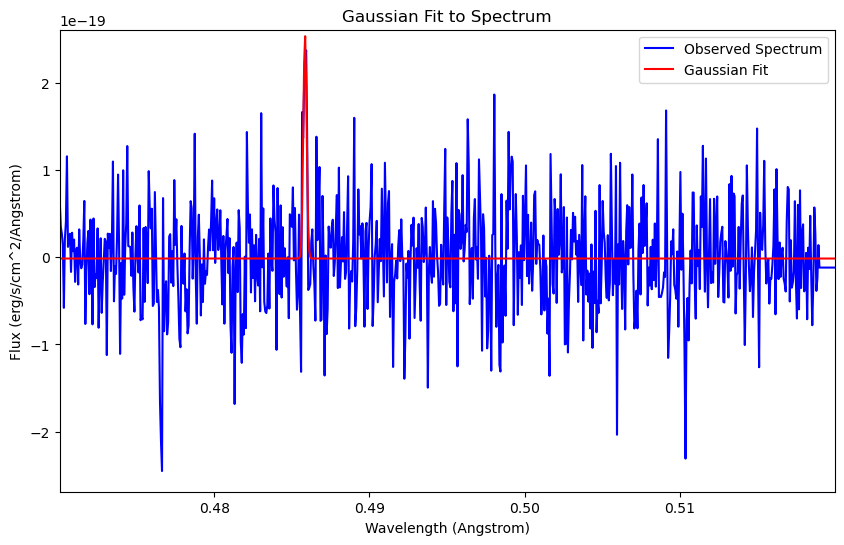

Fitted parameters:
Amplitude: 2.56477658477914e-19
Mean: 0.48584747747381823
Sigma: -0.00010651281317369876
Offset: -1.3701222401169987e-21


In [44]:
popt, pcov = curve_fit(Gaussian, wavelength_range, flux_range, p0=initial_guess,maxfev=800000)
amp_fit, mean_fit, sigma_fit, offset_fit = popt

x_fit= wavelength_range
y_fit = Gaussian(x_fit, *popt)
plt.figure(figsize=(10, 6))
plt.plot(wavelength_range, flux_range, label='Observed Spectrum', color='blue')
plt.plot(x_fit, y_fit, label='Gaussian Fit', color='red')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Gaussian Fit to Spectrum')
plt.legend()
plt.xlim(wavelength_range[0], wavelength_range[-1])
plt.ylim(np.min(flux_range)-0.1*np.max(flux_range), np.max(flux_range)+0.1*np.max(flux_range))
plt.show()
print(f"Fitted parameters:\nAmplitude: {amp_fit}\nMean: {mean_fit}\nSigma: {sigma_fit}\nOffset: {offset_fit}")

negative sigma

In [49]:
x_fit

array([0.470055  , 0.47012085, 0.4701867 , 0.47025254, 0.47031839,
       0.47038424, 0.47045009, 0.47051594, 0.47058178, 0.47064763,
       0.47071348, 0.47077933, 0.47084517, 0.47091102, 0.47097687,
       0.47104272, 0.47110856, 0.47117441, 0.47124026, 0.47130611,
       0.47137196, 0.4714378 , 0.47150365, 0.4715695 , 0.47163535,
       0.47170119, 0.47176704, 0.47183289, 0.47189874, 0.47196459,
       0.47203043, 0.47209628, 0.47216213, 0.47222798, 0.47229382,
       0.47235967, 0.47242552, 0.47249137, 0.47255721, 0.47262306,
       0.47268891, 0.47275476, 0.47282061, 0.47288645, 0.4729523 ,
       0.47301815, 0.473084  , 0.47314984, 0.47321569, 0.47328154,
       0.47334739, 0.47341324, 0.47347908, 0.47354493, 0.47361078,
       0.47367663, 0.47374247, 0.47380832, 0.47387417, 0.47394002,
       0.47400586, 0.47407171, 0.47413756, 0.47420341, 0.47426926,
       0.4743351 , 0.47440095, 0.4744668 , 0.47453265, 0.47459849,
       0.47466434, 0.47473019, 0.47479604, 0.47486189, 0.47492

In [52]:
y_fit=y_fit*u.Unit('erg / (Angstrom cm2 s)')
x_fit=x_fit*u.Unit('micron').to(u.AA)

In [53]:
import scipy
intensity=scipy.integrate.simpson(y_fit, x_fit)
print(f"Integrated intensity: {intensity}")

Integrated intensity: 9.003447940519257e-22


In [ ]:
Sample_Indices_list=list()
for Index_In_DJA_Catalog_int in range(len(DJA_Catalog_DataFrame)):

    Redshift_float=DJA_Catalog_DataFrame['z'][Index_In_DJA_Catalog_int]

    if (Redshift_float<4)or (Redshift_float>6.5):
        continue

    Spectra_NGrating_int=DJA_Catalog_DataFrame.nGr[Index_In_DJA_Catalog_int]
    if Spectra_NGrating_int<2:
        continue

    Sample_Indices_list.append(Index_In_DJA_Catalog_int)

print('Sample number:', len(Sample_Indices_list))
Sample_Indices_list=np.array(Sample_Indices_list)

FL.Free('Index_In_DJA_Catalog_int')

In [ ]:
for DJA_Catalog_DataFrame_Index_int in Sample_Indices_list:

    Object_Catalog_Dataframe=DJA_Catalog_DataFrame[DJA_Catalog_DataFrame.index==DJA_Catalog_DataFrame_Index_int]

    Object_Prism_fits_File_Name_str=Object_Catalog_Dataframe.file.values[0]
    Object_NGrating_int=Object_Catalog_Dataframe.nGr.values[0]
    Object_Grating_List_str=Object_Catalog_Dataframe.Grating.values[0]
    Object_Redshift_float=Object_Catalog_Dataframe.z.values[0]

    for Grating_Type_str in Object_Grating_List_str.split('   '):
        Grating_Type_str=Grating_Type_str.strip().lower()

        Disperser_Name_str=Grating_Type_str[1:-1]

        Dual_Filter_Flag=False

        if Disperser_Name_str=='140':
            Dual_Filter_Flag=True
            Disperser_Filter_Combination_070_str=Grating_Type_str+'-f070lp'
            Disperser_Filter_Combination_100_str=Grating_Type_str+'-f100lp'
        elif Disperser_Name_str=='235':
            Dual_Filter_Flag=False
            Disperser_Filter_Combination_Single_str=Grating_Type_str+'-f170lp'
        elif Disperser_Name_str=='395':
            Dual_Filter_Flag=False
            Disperser_Filter_Combination_Single_str=Grating_Type_str+'-f290lp'

        if Dual_Filter_Flag:
            try:
                Grating_070_fits_File_Name_str=Object_Prism_fits_File_Name_str.replace('prism-clear', Disperser_Filter_Combination_070_str)
                Grating_100_fits_File_Name_str=Object_Prism_fits_File_Name_str.replace('prism-clear', Disperser_Filter_Combination_100_str)

                if not os.path.exists(DJA_File_Path_str+Grating_070_fits_File_Name_str) or not os.path.exists(DJA_File_Path_str+Grating_100_fits_File_Name_str):
                    print('File not found:', Grating_070_fits_File_Name_str, Grating_100_fits_File_Name_str)
                    continue
                else:
                    print('1')

            except Exception as e:
                print('Error processing dual filter grating:', e)
                continue
        else:
            try:
                Grating_fits_File_Name_str=Object_Prism_fits_File_Name_str.replace('prism-clear', Disperser_Filter_Combination_Single_str)
                if not os.path.exists(DJA_File_Path_str+Grating_fits_File_Name_str):
                    print('File not found:', Grating_fits_File_Name_str)
                    continue
                else:
                    print('1')
            except Exception as e:
                print('Error processing single filter grating:', e)
                continue







In [ ]:
df= pd.read_csv('./DJACatalog.csv')
df

In [ ]:
8974+10804

In [ ]:
df.nGr.sum()